# Yeezy Taught Me - Analysis, dimensionality reduction, and clustering of audio features

Alex Chavez

General Assembly: Data Science (Summer 2016)

## Chop up the beats Kanye!

![Chop up the beats Kanye](assets/images/chop-up-the-beats-kanye.jpg)

# Project Imports

In [149]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import Counter

Pretty charts:

In [150]:
plt.style.use('fivethirtyeight')

# Dataset Overview

As the entire Million Song Dataset comes in at 300 GB and I do not currently have the infrastructure in place to handle the full set of data yet, I will be using the Million Song Subset for the exploratory analysis phase of the project.

The Million Song Subset consists of 10,000 songs (1%, 1.8 GB) selected at random.

The above song_features_df dataframe was the result of joining all the H5 files from the Million Song Dataset (MSD) subset using the ETL script triggered by the `make data_subset` command and other clean up operations performed in a clean up notebook.

## Data Clean Up 

In summary, the following data clean up operations were performed:
- Read all H5 files for a song where the artist's terms are of "alternative rap", "black", "east coast rap", "gangsta", "hip hop", "rap", and "soul". These are hand-picked terms from the set of Kanye West songs that I felt were the most relevant for pulling in similair artists to Kanye West.
- Appended audio features from the H5 files with artist metadata from the official MSD into a master pandas DataFrame
- Added `is_kanye_song` to easily filter for Ye songs
- Additional features were created by the length of the beats, bars, sections segments, and tatums array columns:
    - total_beats
    - total_bars
    - total_sections
    - total_segments
    - total_tatums

## Import Data

In [151]:
song_features_df = pd.read_pickle('../data/processed/msd_subset_song_features_clean_df.pkl')

# Data Analysis Summary

## Feature Densities

For our audio features, let's see how the values are distributed.

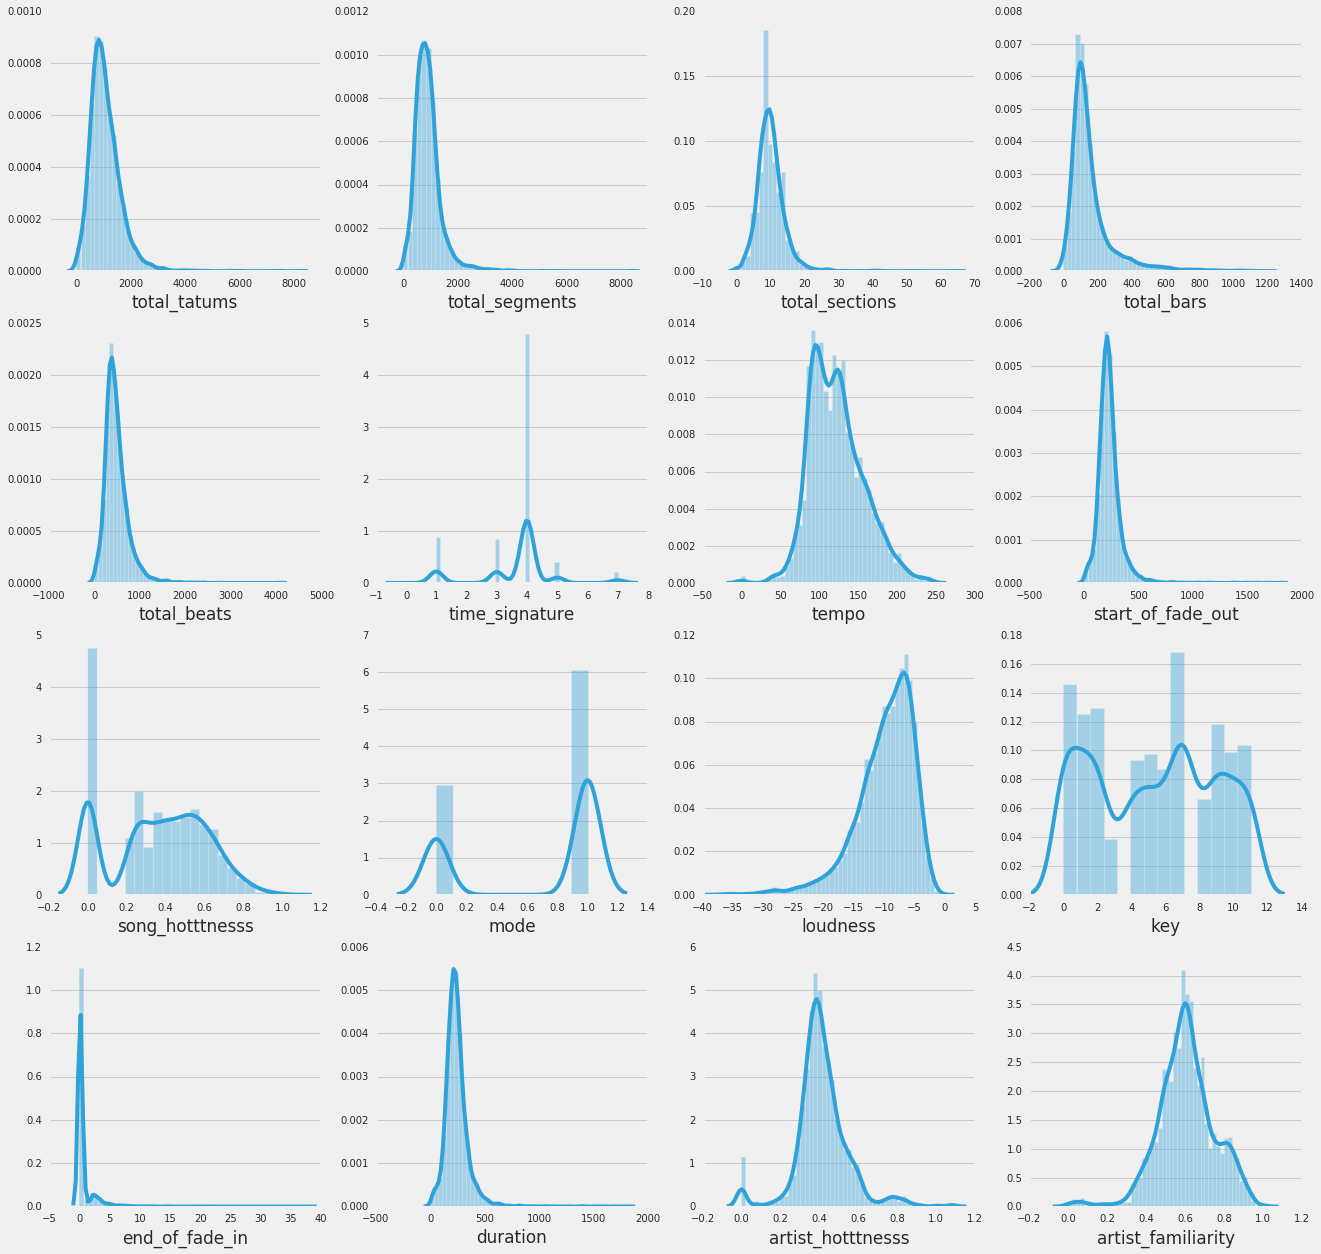

In [152]:
num_rows = 4
num_cols = 4

cols_to_plot = ['artist_familiarity', 'artist_hotttnesss', 'duration',
                'end_of_fade_in', 'key', 'loudness',
                'mode', 'song_hotttnesss', 'start_of_fade_out',
                'tempo', 'time_signature', 'total_beats',
                'total_bars', 'total_sections', 'total_segments',
                'total_tatums']


f, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20), sharex=False)

for i in range(num_rows):
    for j in range(num_cols):
        if len(cols_to_plot) != 0:
            var = cols_to_plot.pop()
            data = song_features_df[var].dropna()
            if data.dtype == np.ndarray:
                data = data.map(len)
            ax = sns.distplot(data, ax=axes[i, j])
            ax.xaxis.grid(False)
            ax.yaxis.grid(True)

### Takeaways

Looks interesting, but without knowing what to expect, it's hard to say if there's is any value of looking at the distribution and densities of the song features at face value. However, we at least know that the distributions of most feature values are not necessarily gaussian or uni-modal, and that several only exist on a discrete scale (e.g. `key`, `mode`, and `time_signature`).

# Principal Component Analysis (PCA)

[Principal Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis), also known as Latent Semantic Indexing (LSI), is a common dimensionality reduction technique that finds the principal components of data. Instead of trying to find patterns in data for all our audio features we can instead use PCA to reduce the feature space into a subspace of fewer dimensions in which the data lies.

![PCA explained figuere](assets/images/fig_pca_principal_component_analysis.png)

## Using PCA

So, what can we do with the above features instead? Let's use PCA in order to emphasize variation and bring light to more subtle patterns in our audio features dataset.

In [153]:
import sklearn
from sklearn import decomposition

Let's get a subset of audio features we want to reduce.

In [154]:
cols_to_plot = ['artist_familiarity', 'artist_hotttnesss', 'duration',
                'end_of_fade_in', 'key', 'loudness',
                'mode', 'song_hotttnesss', 'start_of_fade_out',
                'tempo', 'time_signature', 'total_beats',
                'total_bars', 'total_sections', 'total_segments',
                'total_tatums']

features_to_consider = song_features_df[cols_to_plot].copy(deep=True)

Prep features that are not of type np.ndarray since pca.fit() does not like that.

In [155]:
mask = features_to_consider.dtypes != np.object
features_to_reduce = features_to_consider.loc[:, mask]
features_to_reduce = features_to_reduce.dropna()

Now run the PCA!

In [156]:
pca = decomposition.PCA(n_components=1)
pca.fit(features_to_reduce)
X = pca.transform(features_to_reduce)

### The explained variance ratio

In [157]:
print pca.explained_variance_ratio_

[ 0.8506337]


I initially used PCA to reduce my primary audio features down to four dimensions (or *principal components*). However, it appears that reducing it to one component captures most of the variance in the data.

PCA works by replacing our variables with new components which are orthogonal to the original. The PCA transformation returns a matrix `X` of orthogonal values. The orthogonal has variances (also called eigenvalues) that can be summed diagonally along the matrix to give us the explained variance ratio - which is 0.8506337 / 1.000 ~= **85.06% of the overall variability**.

## Visualizing the New Principal Component

Now that we have projected our features into a subspace of a one-dimensional line, we can easily make out which features stand out between the various songs.

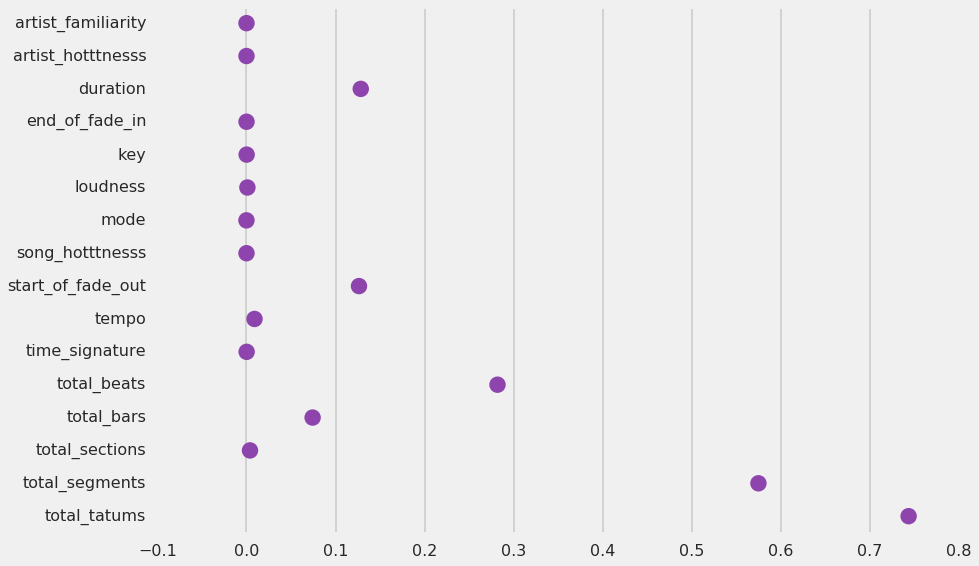

In [158]:
X1 = pca.components_[0] # our principal component

with plt.style.context('seaborn-poster'):
    sns.pointplot(x=X1, y=list(features_to_reduce.columns.values), join=False, color='#8e44ad')

### Takeaways

By plotting our principal component we see that there is significant variance for:

- duration
- start_of_fade_out
- total_beats
- total_bars
- total_segments
- total_tatums

We will use the above identified features in our model as they have the most variance. Furthermore, there isn't a good amount of variance for tempo, loudness, etc. as I would imagine most songs we pulled will naturally have many similar features in the genre of hip hop, rap, and soul.

# Clustering Songs Using K-Means

Next, we will use an unsupervised learning algorithm to discover groups of related artits using out audio features. Clustering is a common and fundamental example of unsupervised learning as it will try to find meaningful groups within data.

## What is K-Means Clustering?

K-Means clustering is a popular centroid-based clustering algorithm. The basic idea is to find `k` clusters in the data centrally located around various mean points. The algorithm seeks to minimize the sum of squares about the means.

The K-Means algorithm can be summarized by these steps:

1. Start with initial `k` mean values
1. Data points are split into a Voroni diagram
1. Assign each point to the "closest" mean
1. Calculate new means based on centroids
1. Repeat until clusters no longer change

![The K-Means clustering algorithm](assets/images/k-means-clustering-algorithm.png)

## Executing the K-Means Clustering Algorithm

Now that we know which features from our songs dataset have the most variance from our data points, we will use them in our clustering algorithm to group sets of related songs together.

In [159]:
features = [
    'duration',
    'start_of_fade_out',
    'tempo',
    'total_bars',
    'total_beats',
    'total_segments',
    'total_tatums'
]

Next let's run the K-Means implementation from scikit-learn to "discover" three groups using the above audio features.

In [160]:
from sklearn.cluster import KMeans

estimator = KMeans(n_clusters=3)
X = song_features_df[features]
estimator.fit(X)

# Clusters are given in the labels_ attribute
labels = estimator.labels_

# Save the identified cluster to our DataFrame
song_features_df['cluster'] = pd.Series(labels, index=song_features_df.index)

## Clustering Analysis

### What groups were discovered?

In [161]:
# Identified clusters
print Counter(labels)

Counter({0: 2397, 1: 1914, 2: 299})


### What Clusters did Ye show up in?

In [162]:
kanye_songs = song_features_df[song_features_df['is_kanye_song'] == 1]

In [163]:
kanye_clusters = sorted(kanye_songs['cluster'].unique())
print kanye_clusters

[0, 1]


### How do these groups differentiate from each other?

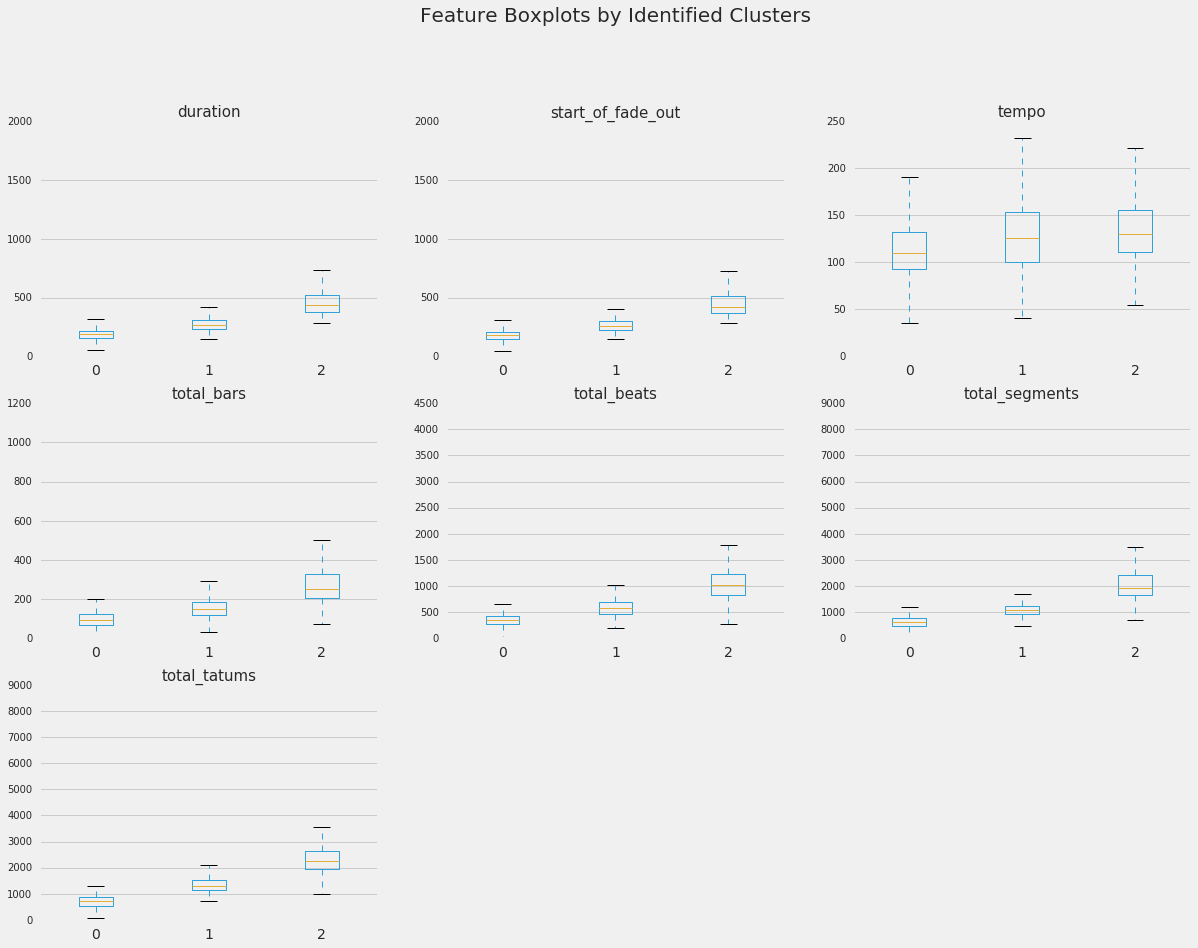

In [164]:
num_rows = 3
num_cols = 4

plt.figure(figsize=(20,20))

for i in range(len(features)):
    v = i + 1
    ax1 = song_features_df.boxplot(features[i], by='cluster', ax=plt.subplot(num_cols, num_rows, v))
    ax1.set_title(str(features[i]), fontsize=15)
    ax1.set_xlabel('')
    ax1.xaxis.grid(False)
    ax1.yaxis.grid(True)

plt.suptitle('Feature Boxplots by Identified Clusters', size=20)

### What songs are in these clusters?

Looking at box plots is pretty neat for data geeks, but doesn't tell us much of what K-Means clustering discovered. What songs are in our three identified clusters?

Print the top 15 songs for each cluster by artist popularity:

In [165]:
clusters = sorted(song_features_df['cluster'].unique())
for i in clusters:
    cluster_group = song_features_df[song_features_df['cluster'] == i]
    cluster_group = cluster_group[pd.notnull(cluster_group['artist_hotttnesss'])]
    cluster_group.sort_values(by='artist_hotttnesss', ascending=False, inplace=True)
    print 'Top 10 Songs (By Aritst Popularity) for Cluster %s' %i
    print
    print cluster_group[['artist_name', 'title', 'artist_hotttnesss']].head(15)
    print

Top 10 Songs (By Aritst Popularity) for Cluster 0

                                  artist_name  \
318                                Kanye West   
2643                               Kanye West   
1060                               Kanye West   
3222                 Kanye West / Lupe Fiasco   
4289                               Kanye West   
1276                          Black Eyed Peas   
1750  Black Eyed Peas / Les Nubians / Mos Def   
540                           Black Eyed Peas   
2080                                  Rihanna   
1150                                  Rihanna   
1510                                   Eminem   
2186                                    Usher   
1743                                    Usher   
3257                              Chris Brown   
2535                                    Usher   

                                       title  artist_hotttnesss  
318                            Street Lights           1.082503  
2643                    School S

From the above data table we can see that Clusters {0, 1} have more hip hop and rap songs as expected. Cluster 2 has a lot of rock and pop songs that I presume were incorrectly tagged in our data set and came as an unexpected surprise.

In the above data table `artist_hotttnesss` corresponds to how much buzz the artist was getting back in 2010 when our Million Song Dataset - err subset, was created. This is derived from many sources, including mentions on the web, mentions in music blogs, music reviews, play counts, etc. The reason Kanye West tops the `artist_hotttnesss` for Cluters {0, 1} can be explained by his infamous incident with Taylor Swift in the 2009 MTV Video Music Awards.


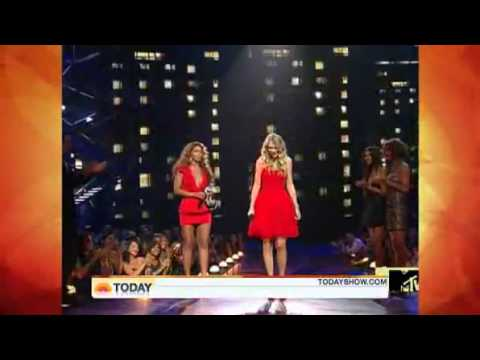

In [166]:
from IPython.display import YouTubeVideo
from datetime import timedelta

start_point = int(timedelta(seconds=11).total_seconds())
YouTubeVideo("z4xWU8o2cvA", start=start_point, autoplay=0)

A Google Trends search for "Kanye West" reveals there was a peak of interest in September 2009 due to Kanye's highly publicized antics at the VMA's.

![Searching "Kanye West" on Google Trends](assets/images/kanye-google-trends.png)

### Clustering Metrics

In order to evaluate our model fit of our clustering algorithm we use a metric called the **Silhouette Coefficient**.

The Silhouette Coefficient is:

$ \frac{b - a}{\max \left (a, b \right )} $

It's calculated such that:

- **a** is the mean distance between a sample and all other points in the cluster
- **b** is the mean distance between a sample and all other points in the nearest cluster
- Ranges between -1 and 1
- Averages over all points to judge the classifier

### The Silhouette Coefficient

We can use the metrics module from scikit-learn to calculate the Silhouette Coefficient for our fitted K-Means estimator.

In [167]:
from sklearn import metrics
metrics.silhouette_score(X, labels, metric='euclidean')

0.40577322064932875

Silhoette coefficients near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.

For three clusters, the **average silhouette score is 0.405**. This means that there were some places where the K-Means algorithm must have had some trouble distinguising neighboring clusters near the decision boundary.

#### What happened?

# Calculating Similarity

Decided to treat the songs returned by our clusters as a geometry problem:

- Measure the angle between artists similar to Kanye West by their audio features using cosine distance
- Songs with smaller angles are more similar
- Other distance metrics available Jaccard similarity, TF-IDF, BM25, etc.

Measuring the cosine distance is a quick and dirty way to calculate a rank.

In [168]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculate the cosine similarity between our
# subset of Ye songs and the rest of our songs
# dataset
X = kanye_songs[features]
Y = song_features_df[features]
similarity = cosine_similarity(X, Y)

# Store the cosine distance results in our dataframe
song_features_df['cosine_distance'] = similarity.T.tolist()

In [25]:
def get_max_cosine_distance(distances):
    max_distance = 0.0
    for idx, d in enumerate(distances):
        if d != 1.0 and d > max_distance:
            max_distance = d
    return max_distance

In [233]:
def get_top_matches(df):
    top_matches = df.copy(deep=True)
    top_matches['kanye_similarity'] = top_matches['cosine_distance'].apply(get_max_cosine_distance)
    top_matches['title'] = top_matches['title'].apply(lambda t: t[:30])
    top_matches = top_matches.groupby(['artist_name', 'title'])['kanye_similarity'].apply(np.max)
    top_matches = top_matches.sort_values(ascending=False)
    return top_matches.head(50)

We know that Kanye West started off his music career as a producer. Ye became Jay-Z's go-to-producer after he produced a few songs for one of Hov's most well received albums - "The Blueprint".

Let's use the fact that Kanye West started to become known in the mainstream after his collaboration with Jay-Z in 2001.

In [234]:
clean_years = song_features_df[song_features_df['year'] >= 2001]

## Songs from Cluster 0

In [235]:
cluster_0 = clean_years[clean_years['cluster'] == 0]
print get_top_matches(cluster_0)

artist_name                         title                         
Kanye West                          Street Lights                     1.000000
                                    Skit #2 (Kanye West/Late Regis    0.999972
Snowgoons                           Michael Nobody aka Poetic Deat    0.999859
Little Brother                      Second Chances feat. Bilal & D    0.999853
Pacha Massive                       Don't let go                      0.999843
Mobb Deep                           Got It Twisted                    0.999778
Snowgoons                           Real World                        0.999778
Redman                              Suicide                           0.999764
Fat Joe                             My FoFo  (Album Version - Amen    0.999762
Plies featuring Tank                You (featuring Tank) (Amended     0.999757
Beyoncé                             Krazy In Luv                      0.999745
Bombay Rockers                      Rock Tha Party              

## Songs from Cluster 1

In [223]:
cluster_1 = clean_years[clean_years['cluster'] == 1]
print get_top_matches(cluster_1)

artist_name                                                  title                         
Kanye West                                                   Diamonds From Sierra Leone        1.000000
Princess Lover                                               Prends-Moi La Main                0.999983
Brooke Valentine                                             Taste Of Dis (Explicit Version    0.999976
themselves                                                   Crayon Sharpener                  0.999962
Rakim feat. Tracey Horton                                    Won't Be Long                     0.999956
Twista                                                       Had To Call (featuring Snoop D    0.999937
Aesop Rock                                                   Flashflood                        0.999910
Sub Focus                                                    Juno                              0.999909
Eddie                                                        Pode Me Chamar 

# Interpretation

Kanye West has in fact produced and collaborated for Twista, Fat Joe, Jay-Z, T.I., B.o.B, Beyonce, Rihana, Janet Jackson and more! By using the cosine distance metric with our audio features that were identified by our Principal Component Analysis, we got a good list of related artists. It's not perfect, but it's a good starting point!

## Songs Produced by Kanye

These songs are not in our MSD subset, but including them here so you can get a feel for some classic hits that were produced by Kanye West and influence it had on some of the artists later songs in the section.

Twista (feat. Kanye West) - Overnight Celebrity:

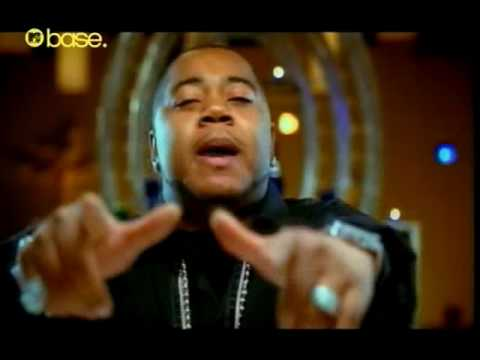

In [117]:
YouTubeVideo("TVpIOvpM5eU")

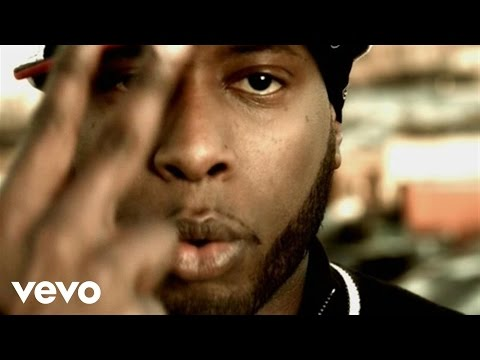

In [201]:
start_point = int(timedelta(minutes=1).total_seconds())
YouTubeVideo("UVtpXvzzXiA", start=start_point)

T.I. - Let Me Tell You Something:

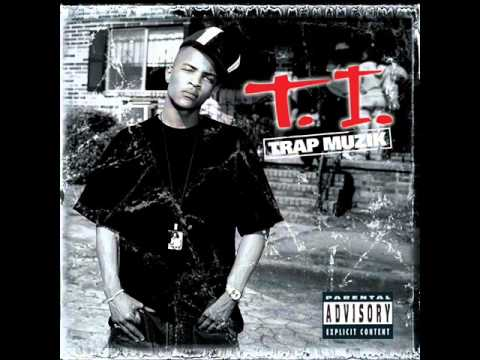

In [118]:
YouTubeVideo("VfDaemwo1NY")

Ye and Hov making "Lucifer":

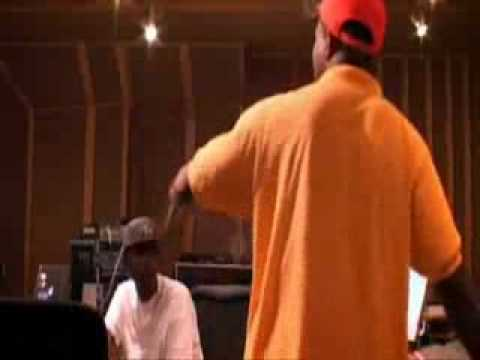

In [120]:
start_point = int(timedelta(minutes=1, seconds=54).total_seconds())
YouTubeVideo("PdyyNJcNavw", start=start_point, autoplay=0)

Kanye West - Heard 'Em Say

## Head-to-Head: Chimpmunk Soul

Yeezy is know in the music industry for his use of [Chimpmunk Soul](https://en.wikipedia.org/wiki/Chicago_hip_hop#.22Chipmunk_soul.22) sampling and pitching-up of soul vocals. Maybe something can be said of Kanye West influencing hip hop, rap, and soul artists?

Kanye West - "Heard 'Em Say":

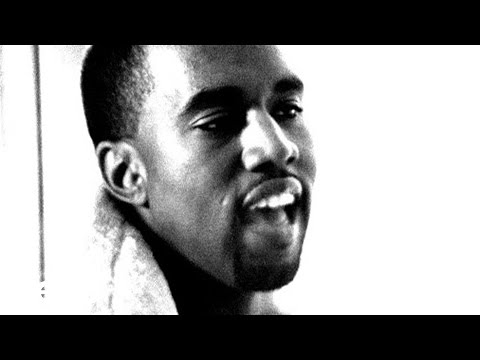

In [123]:
start_point = int(timedelta(seconds=20).total_seconds())
YouTubeVideo("elVF7oG0pQs", start=start_point, autoplay=0)

Talib Kweli - "Everything Man":

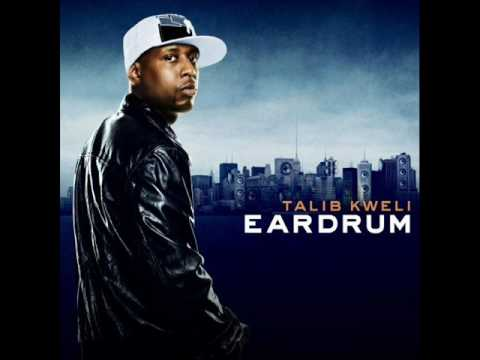

In [207]:
start_point = int(timedelta(minutes=1, seconds=15).total_seconds())
YouTubeVideo("2rRmRKugWow", start=start_point, autoplay=0)

JAY-Z (feat. Pharrel) - "Change Clothes":

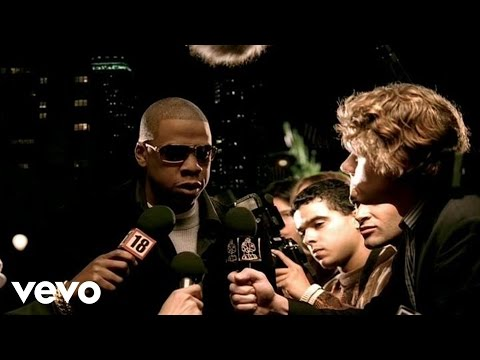

In [202]:
start_point = int(timedelta(seconds=28).total_seconds())
YouTubeVideo("j6G1uwe20wg", start=start_point, autoplay=0)

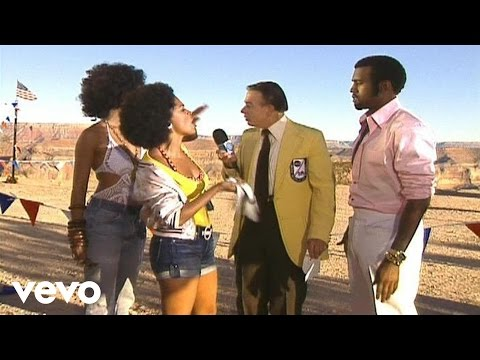

In [203]:
start_point = int(timedelta(minutes=3, seconds=30).total_seconds())
YouTubeVideo("YkwQbuAGLj4", start=start_point, autoplay=0)

B.o.B. (feat. Bruno Mars) - "Nothin' On You"

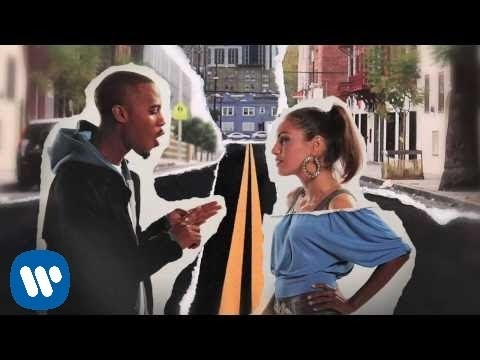

In [206]:
start_point = int(timedelta(minutes=1, seconds=30).total_seconds())
YouTubeVideo("8PTDv_szmL0", start=start_point)

Kanye West - "Diamonds From Sierra Leone":

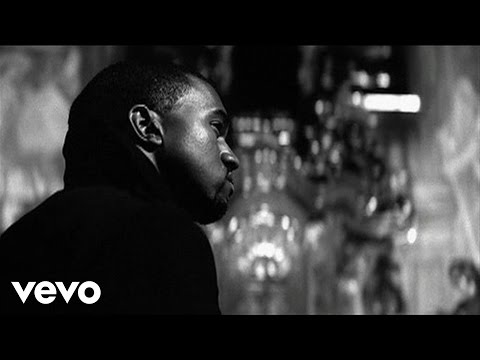

In [134]:
start_point = int(timedelta(minutes=2, seconds=8).total_seconds())
YouTubeVideo("92FCRmggNqQ", start=start_point, autoplay=0)

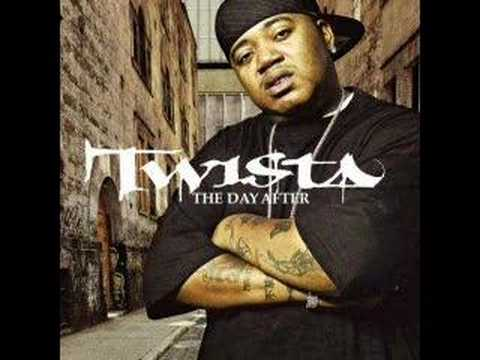

In [210]:
start_point = int(timedelta(seconds=28).total_seconds())
YouTubeVideo("jDq7Eit9-9o", start=start_point, autoplay=0)